In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parámetros de la simulación
num_particulas = 160
num_pasos = 100
num_simulaciones = 1
dt = 1.0

# Parámetros de la caja y obstáculos
caja_size = 125.0
num_obstaculos = 20
tamano_obstaculos_max = np.sqrt(caja_size**2 / num_obstaculos)


In [3]:
# Probabilidad de ir a la derecha es el doble que ir a la izquierda
prob_derecha = 2 / 3 
prob_izquierda = 1/ 3

In [4]:
# Elasticidad del rebote (0 = totalmente inelástico, 1 = totalmente elástico)
elasticity = 0.9  # Ajusta según la elasticidad deseada

In [5]:
# Crear una matriz para almacenar los MSD de cada simulación en la dirección x e y
msd_simulaciones_x = np.zeros((num_simulaciones, num_pasos + 1))
msd_simulaciones_y = np.zeros((num_simulaciones, num_pasos + 1))

In [6]:
# Crear listas para almacenar los resultados de cada simulación en ambas direcciones
distribucion_pasos_simulaciones_x = []
distribucion_pasos_simulaciones_y = []
distribucion_angulos_simulaciones_x = []
distribucion_angulos_simulaciones_y = []
trayectorias_simulaciones_x = []
trayectorias_simulaciones_y = []

In [9]:
for sim in range(num_simulaciones):
    # Creación de un arreglo para almacenar las posiciones de las partículas
    posiciones_x = np.zeros((num_particulas, num_pasos + 1))
    posiciones_y = np.zeros((num_particulas, num_pasos + 1))

    # Inicialización de las posiciones
    posiciones_x[:, 0] = np.random.uniform(-caja_size / 2, caja_size / 2, size=num_particulas)
    posiciones_y[:, 0] = np.random.uniform(-caja_size / 2, caja_size / 2, size=num_particulas)

    # Crear obstáculos (partículas grandes inmóviles)
    posiciones_obstaculos_x = np.random.uniform(-caja_size / 2, caja_size / 2, size=num_obstaculos)
    posiciones_obstaculos_y = np.random.uniform(-caja_size / 2, caja_size / 2, size=num_obstaculos)
    # Simulación del movimiento browniano con colisiones en la caja
    for i in range(num_pasos):
        # Generación de pasos aleatorios en ambas direcciones (x e y)
        random_steps_x = np.random.normal(0, np.sqrt(dt), size=num_particulas)
        random_steps_y = np.random.normal(0, np.sqrt(dt), size=num_particulas)

         # Generación de ángulos aleatorios en ambas direcciones (0 a 360 grados en radianes)
        angulos_x = 2 * np.pi * np.random.random(num_particulas)  # 0 a 2*pi radianes (360 grados)
        angulos_y = 2 * np.pi * np.random.random(num_particulas)  # 0 a 2*pi radianes (360 grados)
        
        # Cálculo de las direcciones en ambas direcciones
        # Elección aleatoria de dirección (0 grados o 180 grados)
        direcciones_x = np.random.choice([-1, 1], size=num_particulas, p=[prob_izquierda, prob_derecha])
        direcciones_y = np.random.choice([-1, 1], size=num_particulas, p=[prob_izquierda, prob_derecha])
        
       
        # Actualización de las posiciones
        posiciones_x[:, i+1] = posiciones_x[:, i] + random_steps_x.flatten()
        posiciones_y[:, i+1] = posiciones_y[:, i] + random_steps_y.flatten()

        
        # Actualización de las posiciones en ambas direcciones
        posiciones_x[:, i+1] = posiciones_x[:, i] + random_steps_x.flatten() * direcciones_x
        posiciones_y[:, i+1] = posiciones_y[:, i] + random_steps_y.flatten() * direcciones_y

        # Reflexión en las paredes de la caja
        posiciones_x[:, i+1] = np.clip(posiciones_x[:, i+1], -caja_size / 2, caja_size / 2)
        posiciones_y[:, i+1] = np.clip(posiciones_y[:, i+1], -caja_size / 2, caja_size / 2)
        
        # Detectar colisiones con obstáculos y realizar rebote
        for j in range(num_obstaculos):
            dx = posiciones_x[:, i+1] - posiciones_obstaculos_x[j]
            dy = posiciones_y[:, i+1] - posiciones_obstaculos_y[j]
            distancias = np.sqrt(dx**2 + dy**2)

            # Comprueba colisiones y realiza rebote ajustando la dirección de las partículas
            colisiones = distancias < (tamano_obstaculos_max / 2)
            if np.any(colisiones):
                # Ajusta la dirección de las partículas en función de la normal al obstáculo
                dx_normalized = dx / distancias
                dy_normalized = dy / distancias
                dot_product = 2 * (random_steps_x[colisiones] * dx_normalized[colisiones] + random_steps_y[colisiones] * dy_normalized[colisiones])
                random_steps_x[colisiones] -= dot_product * dx_normalized[colisiones]
                random_steps_y[colisiones] -= dot_product * dy_normalized[colisiones]
                random_steps_x[colisiones] *= elasticity  # Ajusta la velocidad
                random_steps_y[colisiones] *= elasticity

                # Restablece la posición para evitar superposiciones
                posiciones_x[colisiones, i+1] = posiciones_x[colisiones, i]
                posiciones_y[colisiones, i+1] = posiciones_y[colisiones, i]

In [10]:
# Cálculo del Mean Square Displacement (MSD) para esta simulación en ambas direcciones
msd_simulaciones_x[sim] = np.mean((posiciones_x - posiciones_x[:, 0][:, np.newaxis])**2, axis=0)
msd_simulaciones_y[sim] = np.mean((posiciones_y - posiciones_y[:, 0][:, np.newaxis])**2, axis=0)

# Cálculo de la distribución de pasos en ambas direcciones para esta simulación
distribucion_pasos_simulaciones_x.append(np.sqrt((posiciones_x[:, 1:] - posiciones_x[:, :-1])**2).flatten())
distribucion_pasos_simulaciones_y.append(np.sqrt((posiciones_y[:, 1:] - posiciones_y[:, :-1])**2).flatten())

# Cálculo de los ángulos theta en ambas direcciones para esta simulación
theta_x = np.arctan2(posiciones_y[:, 1:] - posiciones_y[:, :-1], posiciones_x[:, 1:] - posiciones_x[:, :-1])
distribucion_angulos_simulaciones_x.append(theta_x.flatten())
theta_y = np.arctan2(posiciones_x[:, 1:] - posiciones_x[:, :-1], posiciones_y[:, 1:] - posiciones_y[:, :-1])
distribucion_angulos_simulaciones_y.append(theta_y.flatten())

    # Almacenar las trayectorias para esta simulación
trayectorias_simulaciones_x.append(posiciones_x)
trayectorias_simulaciones_y.append(posiciones_y)

In [11]:
# Cálculo del MSD promedio en ambas direcciones
msd_promedio_x = np.mean(msd_simulaciones_x, axis=0)
msd_promedio_y = np.mean(msd_simulaciones_y, axis=0)

# Cálculo del coseno de theta promedio en ambas direcciones
coseno_theta_promedio_x = np.mean(np.cos(np.array(distribucion_angulos_simulaciones_x)), axis=0)
coseno_theta_promedio_y = np.mean(np.cos(np.array(distribucion_angulos_simulaciones_y)), axis=0)

# Cálculo del coeficiente de difusión promedio en ambas direcciones
epsilon = 1e-10  # Pequeña cantidad para evitar la división por cero
coeficiente_difusion_x = msd_promedio_x / (2 * np.arange(num_pasos + 1) * dt + epsilon)
coeficiente_difusion_y = msd_promedio_y / (2 * np.arange(num_pasos + 1) * dt + epsilon)

In [12]:
# Crear gráficas para ambas direcciones
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

Text(0, 0.5, 'Densidad')

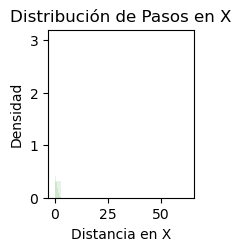

In [13]:
plt.subplot(231)
for distribucion_pasos in distribucion_pasos_simulaciones_x:
    plt.hist(distribucion_pasos, bins=20, density=True, alpha=0.1, color='g')
plt.title('Distribución de Pasos en X')
plt.xlabel('Distancia en X')
plt.ylabel('Densidad')

Text(0, 0.5, 'MSD (µm^2)')

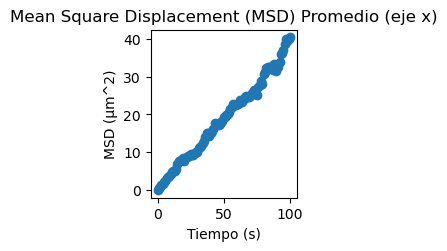

In [14]:
plt.subplot(232)
plt.plot(np.arange(num_pasos + 1) * dt, msd_promedio_x, marker='o', linestyle='-')
plt.title('Mean Square Displacement (MSD) Promedio (eje x)')
plt.xlabel('Tiempo (s)')
plt.ylabel('MSD (µm^2)')

Text(0, 0.5, 'Densidad')

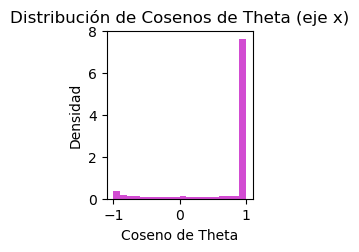

In [15]:
plt.subplot(236)
cosenos_theta_all_x = np.cos(np.concatenate(distribucion_angulos_simulaciones_x))
plt.hist(cosenos_theta_all_x, bins=20, density=True, color='m', alpha=0.7)
plt.title('Distribución de Cosenos de Theta (eje x)')
plt.xlabel('Coseno de Theta')
plt.ylabel('Densidad')

Text(0, 0.5, 'Posición')

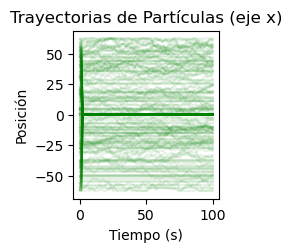

In [16]:
plt.subplot(234)
for trayectorias_x in trayectorias_simulaciones_x:
    for i in range(num_particulas):
        plt.plot(np.arange(num_pasos + 1) * dt, trayectorias_x[i, :], alpha=0.1, color='g')
plt.title('Trayectorias de Partículas (eje x)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición')

Text(0, 0.5, 'Coeficiente de Difusión (µm^2/s)')

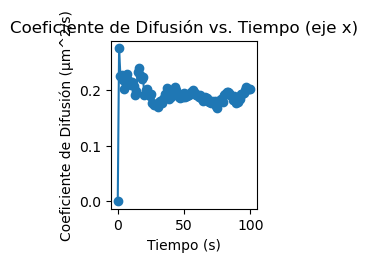

In [17]:
plt.subplot(235)
plt.plot(np.arange(num_pasos + 1) * dt, coeficiente_difusion_x, marker='o', linestyle='-')
plt.title('Coeficiente de Difusión vs. Tiempo (eje x)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Coeficiente de Difusión (µm^2/s)')

Text(0, 0.5, 'Densidad')

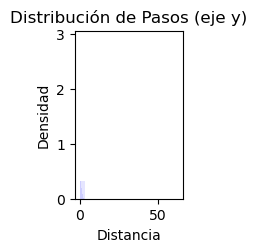

In [18]:
# Gráficas para la dirección y
plt.subplot(241)
for distribucion_pasos_y in distribucion_pasos_simulaciones_y:
    plt.hist(distribucion_pasos_y, bins=20, density=True, alpha=0.1, color='b')
plt.title('Distribución de Pasos (eje y)')
plt.xlabel('Distancia')
plt.ylabel('Densidad')

Text(0, 0.5, 'MSD (µm^2)')

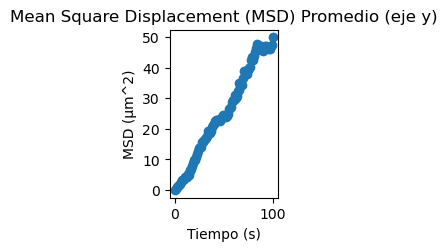

In [19]:
plt.subplot(242)
plt.plot(np.arange(num_pasos + 1) * dt, msd_promedio_y, marker='o', linestyle='-')
plt.title('Mean Square Displacement (MSD) Promedio (eje y)')
plt.xlabel('Tiempo (s)')
plt.ylabel('MSD (µm^2)')

Text(0, 0.5, 'Densidad')

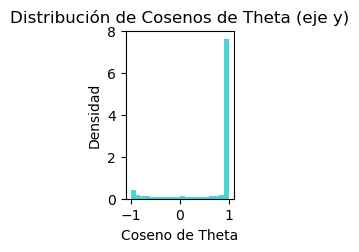

In [20]:
plt.subplot(246)
cosenos_theta_all_y = np.cos(np.concatenate(distribucion_angulos_simulaciones_y))
plt.hist(cosenos_theta_all_y, bins=20, density=True, color='c', alpha=0.7)
plt.title('Distribución de Cosenos de Theta (eje y)')
plt.xlabel('Coseno de Theta')
plt.ylabel('Densidad')

Text(0, 0.5, 'Posición')

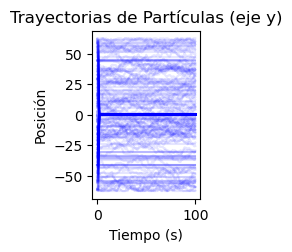

In [21]:
plt.subplot(244)
for trayectorias_y in trayectorias_simulaciones_y:
    for i in range(num_particulas):
        plt.plot(np.arange(num_pasos + 1) * dt, trayectorias_y[i, :], alpha=0.1, color='b')
plt.title('Trayectorias de Partículas (eje y)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición')

Text(0, 0.5, 'Coeficiente de Difusión (µm^2/s)')

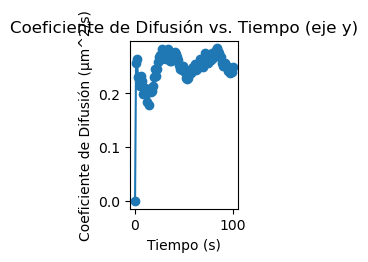

In [22]:
plt.subplot(245)
plt.plot(np.arange(num_pasos + 1) * dt, coeficiente_difusion_y, marker='o', linestyle='-')
plt.title('Coeficiente de Difusión vs. Tiempo (eje y)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Coeficiente de Difusión (µm^2/s)')

In [23]:
# Crear un array para la autocorrelación de velocidades en la dirección x
autocorrelacion_velocidades_x = np.zeros(num_pasos - 1)  # Nota el ajuste del tamaño
autocorrelacion_velocidades_y = np.zeros(num_pasos - 1)

In [24]:
# Cálculo de velocidades en la dirección x
velocidades_x = np.diff(posiciones_x, axis=1) / dt
velocidades_y = np.diff(posiciones_y, axis=1) / dt

In [25]:
for tau in range(num_pasos - 1):
        # Calcula la suma de productos de velocidades con desplazamiento
        cv_x = np.mean(np.sum(velocidades_x[:, :num_pasos - tau] * velocidades_x[:, tau:], axis=1))
        autocorrelacion_velocidades_x[tau] = cv_x
        # Calcula la suma de productos de velocidades con desplazamiento en la dirección y
        cv_y = np.mean(np.sum(velocidades_y[:, :num_pasos - tau] * velocidades_y[:, tau:], axis=1))
        autocorrelacion_velocidades_y[tau] = cv_y

In [26]:
# Convierte la lista en un array NumPy
autocorrelacion_velocidades_x = np.array(autocorrelacion_velocidades_x)
autocorrelacion_velocidades_y = np.array(autocorrelacion_velocidades_y)

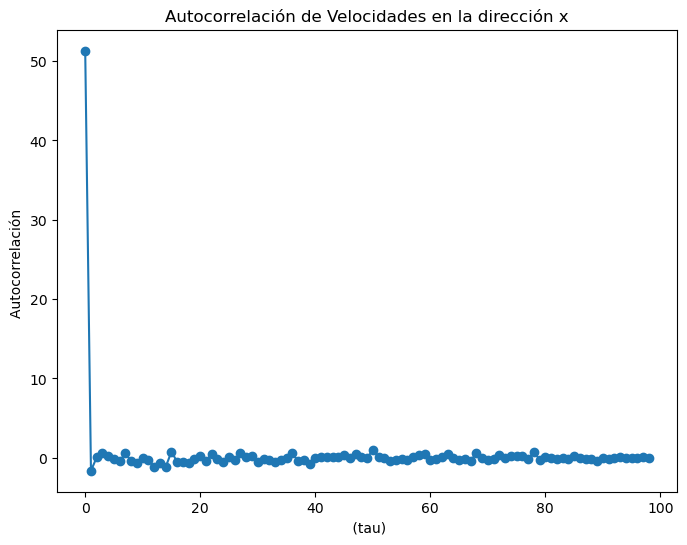

In [27]:
# Grafica la autocorrelación de velocidades en la dirección x
plt.figure(figsize=(8, 6))
plt.plot(np.arange(num_pasos - 1) * dt, autocorrelacion_velocidades_x, marker='o', linestyle='-')
plt.title('Autocorrelación de Velocidades en la dirección x')
plt.xlabel(' (tau)')
plt.ylabel('Autocorrelación ')
plt.show()

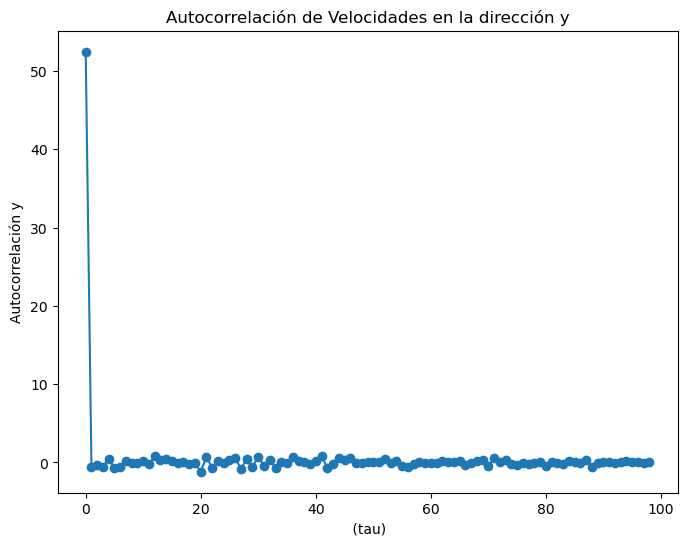

In [28]:
# Grafica la autocorrelación de velocidades en la dirección y
plt.figure(figsize=(8, 6))
plt.plot(np.arange(num_pasos - 1) * dt, autocorrelacion_velocidades_y, marker='o', linestyle='-')
plt.title('Autocorrelación de Velocidades en la dirección y')
plt.xlabel(' (tau)')
plt.ylabel('Autocorrelación y')
plt.show()